# Validate Model and Visulize the Result

In [38]:
# Imports and configuration
import torch
import numpy as np
import os
import config
import net
from Dataset import *
from utils import data_transforms
import torch.nn.functional as F

In [39]:
model = net.SiameseResNet()
model_file = '/media/solomentsev/HDD1/datasets/DeepSim_dataset/models/SiameseResNet_2024-05-22-13-05_best.pth'
dataset_type = 'img' # or h5?

/home/solomentsev/anaconda3/envs/deepsim/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/solomentsev/anaconda3/envs/deepsim/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Load models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(config.MODEL_DIR, model_file)
model.load_state_dict(torch.load(model_file))
model.eval()
model.to(device)

RuntimeError: Error(s) in loading state_dict for SiameseResNet:
	Missing key(s) in state_dict: "fc.4.weight", "fc.4.bias", "fc.4.running_mean", "fc.4.running_var", "fc.8.weight", "fc.9.weight", "fc.9.bias". 
	Unexpected key(s) in state_dict: "fc.5.weight". 
	size mismatch for fc.3.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 2048]).
	size mismatch for fc.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc.6.weight: copying a param with shape torch.Size([8, 512]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for fc.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([512]).

In [35]:
# Load datasets
batch_size = 1
if dataset_type == 'h5':
    feature_file = config.FULL_RESIZED_FEATURE
    image_datasets = {x: SatAerH5Dataset(csv_file=os.path.join(config.MID_PRODUCT, '%s.csv' % x),
                                         feature_file=feature_file) for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
elif dataset_type == 'img':
    image_datasets = {x: SatUAVDataset(csv_meta=f'raw.csv' if x=='train' else 'raw.csv',
                                       csv_file=f'{x}.csv',
                                       root_dir=config.DATA_DIR, 
                                       transform=data_transforms['norm']) for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [36]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [37]:
margin = 4

# Predict and get prediction matrix
output_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}
label_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}
# print(pred_matrix['val'].shape)
import time
since = time.time()
for phase in ['train', 'val']:
    print(phase,"phase:")
    for i_batch, sample_batched in enumerate(dataloaders[phase]):
        print(i_batch+1, '/', dataset_sizes[phase], end = '\r')
        A = sample_batched['A'].to(device)
        B = sample_batched['B'].to(device)
        #labels = sample_batched['label'].to(device)
        with torch.set_grad_enabled(False):
            outputs = model(A,B)
            # output_matrix[phase][i_batch] = outputs.cpu().data.numpy()
            dist = F.pairwise_distance(outputs[0], outputs[1])
            output_matrix[phase][i_batch] = dist.cpu().data.numpy()[:, np.newaxis]
            label_matrix[phase][i_batch] = sample_batched['label'].numpy()[0]
    print()
print((time.time()-since)/(192+48), 'seconds/image (Only time for FC layers)')

train phase:


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [23]:
pred_matrix = {x: (output_matrix[x] > 2)*1 for x in ['train', 'val']}
to_vis_matrix = {x: np.stack((output_matrix[x], pred_matrix[x], label_matrix[x])) for x in ['train', 'val']}
print({x: to_vis_matrix[x].shape for x in ['train', 'val']})

{'train': (3, 688), 'val': (3, 172)}


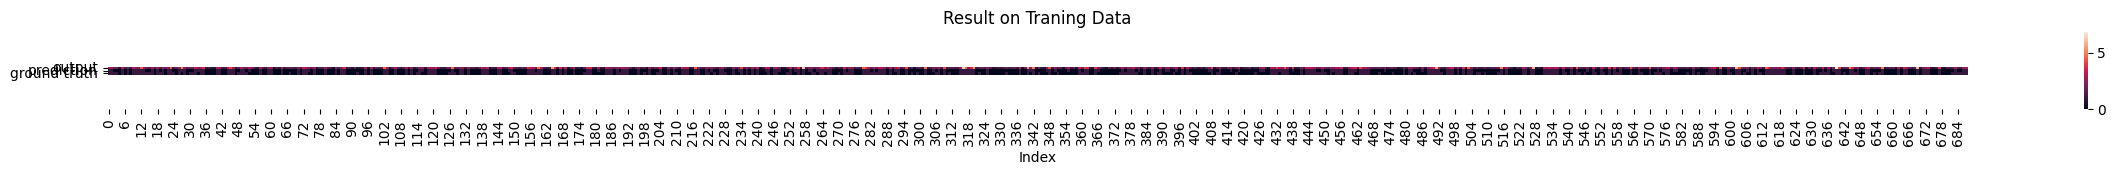

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

fig_size = [30,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['train'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Traning Data')
plt.show()

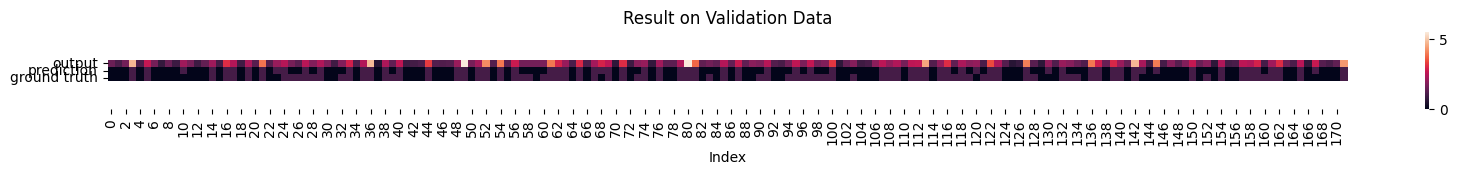

In [25]:
%matplotlib inline

fig_size = [20,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['val'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Validation Data')
plt.show()

In [26]:
# Analyse the result
def confusion_matrix(pred, gt):
    #n = gt.shape[0]
    P = gt == 1
    N = gt == 0

    # tp = np.sum(np.logical_and(gt==pred, pred==1))
    # tn = np.sum(np.logical_and(labels.cpu().data.numpy()==preds, preds==0))
    # fp = np.sum(np.logical_and(labels.cpu().data.numpy()!=preds, preds==1))
    # fn = np.sum(np.logical_and(labels.cpu().data.numpy()!=preds, preds==0))

    
    TP = np.sum(pred[P])
    FP = np.sum(pred[N])
    FN = np.sum(1 - pred[P])
    TN = np.sum(1 - pred[N])
    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

for x in ['train', 'val']:
    print(x, 'data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:')
    print(confusion_matrix(pred_matrix[x], label_matrix[x]))

train data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(254, 44, 306, 84, 0.7514792899408284, 0.12571428571428572, 0.813953488372093, 0.8523489932885906, 0.7514792899408284, 0.7987421383647797)
val data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(67, 8, 73, 24, 0.7362637362637363, 0.09876543209876543, 0.813953488372093, 0.8933333333333333, 0.7362637362637363, 0.8072289156626506)


In [27]:
# Analyse the result
def confusion_matrix(pred, gt):
    #n = gt.shape[0]
    P = gt == 1
    N = gt == 0

    TP = np.sum(np.logical_and(gt==pred, pred==1))
    TN = np.sum(np.logical_and(gt==pred, pred==0))
    FP = np.sum(np.logical_and(gt!=pred, pred==1))
    FN = np.sum(np.logical_and(gt!=pred, pred==0))
    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

for x in ['train', 'val']:
    print(x, 'data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:')
    print(confusion_matrix(pred_matrix[x], label_matrix[x]))

train data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(254, 44, 306, 84, 0.7514792899408284, 0.12571428571428572, 0.813953488372093, 0.8523489932885906, 0.7514792899408284, 0.7987421383647797)
val data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(67, 8, 73, 24, 0.7362637362637363, 0.09876543209876543, 0.813953488372093, 0.8933333333333333, 0.7362637362637363, 0.8072289156626506)


In [28]:
output_matrix

{'train': array([2.80112362, 2.52844453, 1.93101859, 1.98978961, 0.7310226 ,
        2.76114583, 1.30101633, 2.01982355, 1.00735545, 2.9357307 ,
        2.38752174, 2.23450589, 4.36773014, 2.32102942, 1.85874534,
        1.57304847, 2.60417295, 1.36881781, 2.56982017, 1.46866751,
        2.48101091, 1.8663882 , 2.31623054, 4.35811424, 1.12721431,
        1.78851449, 2.3848815 , 4.98355007, 2.36815572, 1.65441513,
        1.85012925, 1.95731175, 3.36520982, 2.32857895, 2.85509133,
        3.62910438, 0.90335119, 1.25455403, 0.88039857, 0.71666634,
        3.10644221, 2.80617118, 1.10344231, 1.27341652, 3.33692813,
        4.06112337, 2.54423213, 0.93841672, 1.57993805, 2.99774551,
        2.05878496, 1.84780967, 2.9726522 , 1.8991847 , 1.24434936,
        0.83460861, 2.74017119, 1.42230892, 1.14297271, 2.55163217,
        2.46350789, 0.38163084, 1.32753205, 0.83802646, 2.66749835,
        1.08661115, 1.54211068, 1.75673282, 1.55864596, 1.35819578,
        2.2495749 , 1.36012256, 3.31035

In [29]:
max_distance = max(np.max(output_matrix['train']), np.max(output_matrix['val']))
max_distance

6.827145099639893

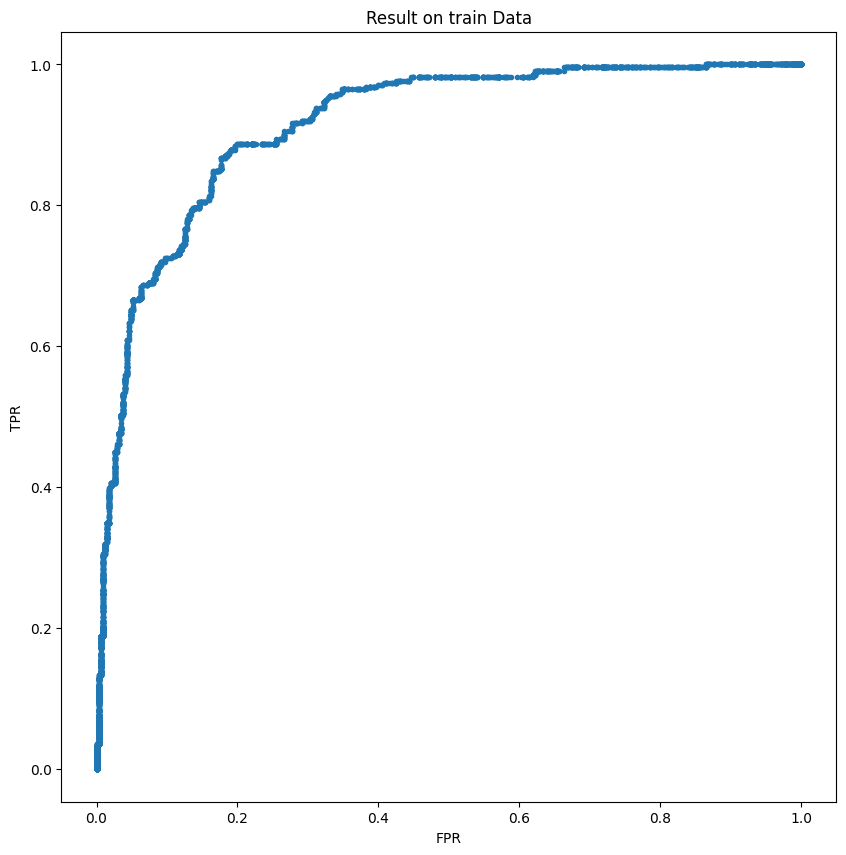

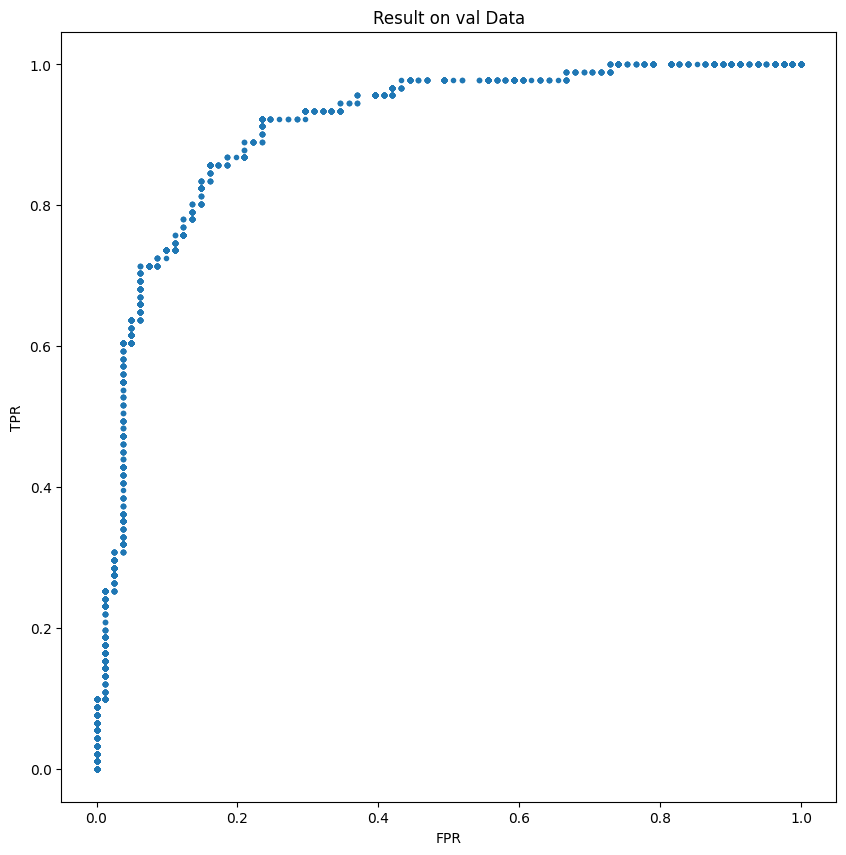

In [31]:
# ROC
np.seterr(divide='ignore',invalid='ignore')
phase = 'train'
for phase in ['train','val']:
    ROC_x, ROC_y = [0], [0]
    for threshold in range(1,1000*int(np.ceil(max_distance))+1):
        pred_matrix = (output_matrix[phase] > threshold/1000.0)*1
        conf_mat = confusion_matrix(pred_matrix, label_matrix[phase])
        x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
        ROC_x.append(x)
        ROC_y.append(y)
    #ROC_x.append(1)
    #ROC_y.append(1)
    #print(ROC_x,ROC_y)
    %matplotlib inline
    plt.gcf().clear()
    fig_size = [10,10]
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')
    plt.plot(ROC_x, ROC_y, '.')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.axis('equal')
    plt.title('Result on '+phase+' Data')
    axes = plt.gca()
    # axes.set_xlim([0., 1.])
    plt.show()


## Those wrong classified images

In [75]:
#
phase = 'train'
def sneaky_results(pred, gt):
    P = gt == 1
    N = gt == 0
    FP = np.logical_and(pred != gt, gt==0)
    FN = np.logical_and(pred != gt, gt==1)
    return np.where(FP)[0], np.where(FN)[0]
for x in ['train', 'val']:
    pred_matrix = (output_matrix[x] > .5)*1
    print(sneaky_results(pred_matrix, label_matrix[x]))

(array([  1,   2,   3,   7,  16,  17,  18,  19,  20,  23,  27,  29,  32,
        33,  34,  37,  42,  46,  47,  48,  50,  55,  56,  57,  64,  65,
        71,  72,  74,  78,  79,  82,  83,  84,  85,  90,  93,  94,  97,
        98, 101, 103, 106, 109, 112, 113, 114, 115, 118, 122, 125, 127,
       130, 131, 132, 133, 134, 140, 142, 143, 144, 145, 149, 150, 152,
       153, 155, 156, 157, 158, 160, 162, 164, 165, 170, 171, 174, 177,
       178, 180, 181, 182, 183, 184, 185, 188, 190, 191, 195, 197, 198,
       204, 205, 207, 209, 211, 214, 217, 219, 221, 226, 231, 233, 237,
       238, 239, 240, 241, 242, 243, 245, 247, 249, 251, 252, 254, 257,
       258, 260, 262, 263, 264, 267, 270, 273, 276, 278, 279, 282, 284,
       285, 288, 289, 290, 291, 293, 297, 302, 303, 304, 306, 307, 309,
       313, 314, 316, 319, 320, 321, 323, 327, 328, 329, 333, 334, 335,
       337, 339, 341, 344, 350, 352, 353, 354, 356, 361, 364, 365, 367,
       370, 372, 373, 375, 377, 378, 381, 382, 385, 386, 387, 3

In [76]:
import pandas as pd
from PIL import Image


def draw_images(indices, phase):
    assert phase in ['train', 'val']
    csv_file = os.path.join(config.FULL_RESIZED, '%s.csv' % phase)
    file_frame = pd.read_csv(csv_file)
    columns = 2
    rows = len(indices)
    fig=plt.figure(figsize=(14, 5*rows))
    for i, idx in enumerate(indices):
        A_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,0])
        B_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,1])
        print(A_name)
        A = Image.open(A_name)
        B = Image.open(B_name)
        fig.add_subplot(rows, columns, 2*i+1)
        plt.imshow(A)
        fig.add_subplot(rows, columns, 2*i+2)
        plt.imshow(B)

    plt.show()

phase = 'train'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)

FileNotFoundError: [Errno 2] No such file or directory: '/media/solomentsev/HDD1/datasets/DeepSim_dataset/dataset/full_resized/train.csv'

./dataset/full_resized/0009_A.jpg


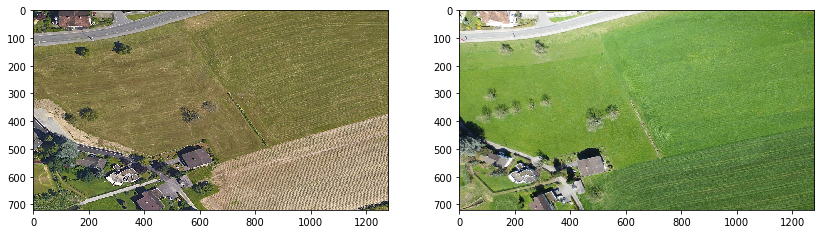

In [26]:
phase = 'val'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)